In [3]:
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets 
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
from thop import profile
from netcal.metrics import ECE

In [4]:
seed = np.random.seed(42)

In [ ]:
import os
import shutil
import random
import urllib.request
import tarfile
import zipfile
import scipy.io
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

def download_and_extract_tgz(url, download_path, extract_path):
    if not os.path.exists(download_path):
        print(f"Baixando em {url} ")
        urllib.request.urlretrieve(url, download_path)
    else:
        print(f"{download_path} já existe")

    if not os.path.exists(os.path.join(extract_path, "jpg")):
        print("Extraindo...")
        with tarfile.open(download_path, "r:gz") as tar:
            tar.extractall(path=extract_path)
        print(f"Extração concluída em {extract_path}")
    else:
        print("Pasta 'jpg' já existe, pulando extração.")

def split_dataset(dataset, val_frac=0.1, seed=42):
    n_val = int(len(dataset) * val_frac)
    n_train = len(dataset) - n_val
    torch.manual_seed(seed)
    return random_split(dataset, [n_train, n_val])

def prepare_flowers102(data_root="data", seed=42):
    import numpy as np

    random.seed(seed)
    np.random.seed(seed)

    flowers_path = os.path.join(data_root, "flowers-102")
    os.makedirs(flowers_path, exist_ok=True)

    url_flowers = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
    tgz_path = os.path.join(flowers_path, "102flowers.tgz")
    img_folder = os.path.join(flowers_path, "jpg")

    if not os.path.exists(img_folder):
        download_and_extract_tgz(url_flowers, tgz_path, flowers_path)

    url_labels = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"
    labels_path = os.path.join(flowers_path, "imagelabels.mat")
    if not os.path.exists(labels_path):
        print("Baixando labels...")
        urllib.request.urlretrieve(url_labels, labels_path)

    labels = scipy.io.loadmat(labels_path)['labels'][0]  
    all_images = sorted(os.listdir(img_folder))

    class_to_images = {i: [] for i in range(1, 103)}
    for img_name in all_images:
        idx = int(img_name[6:11]) - 1  
        label = int(labels[idx])
        class_to_images[label].append(img_name)

    for split_name in ["train", "val", "test"]:
        split_dir = os.path.join(flowers_path, split_name)
        os.makedirs(split_dir, exist_ok=True)

    for cls, imgs in class_to_images.items():
        random.shuffle(imgs)
        n_total = len(imgs)
        n_train = int(0.7 * n_total)
        n_val = int(0.15 * n_total)
        n_test = n_total - n_train - n_val

        splits = {
            "train": imgs[:n_train],
            "val": imgs[n_train:n_train + n_val],
            "test": imgs[n_train + n_val:]
        }

        for split_name, img_list in splits.items():
            label_dir = os.path.join(flowers_path, split_name, str(cls))
            os.makedirs(label_dir, exist_ok=True)
            for img_name in img_list:
                src = os.path.join(img_folder, img_name)
                dst = os.path.join(label_dir, img_name)
                if not os.path.exists(dst):
                    shutil.copy(src, dst)

    return (
        os.path.join(flowers_path, "train"),
        os.path.join(flowers_path, "val"),
        os.path.join(flowers_path, "test")
    )



def load_datasets(batch_size=64, seed=42):
    data_root = "data"
    os.makedirs(data_root, exist_ok=True)

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    transform_train = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        normalize
    ])

    transform_test = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])

    train_dir, val_dir, test_dir = prepare_flowers102(data_root, seed)
    train_flowers = datasets.ImageFolder(train_dir, transform=transform_train)
    val_flowers   = datasets.ImageFolder(val_dir, transform=transform_test)
    test_flowers  = datasets.ImageFolder(test_dir, transform=transform_test)

    tiny_path = os.path.join(data_root, "tiny-imagenet-200")
    if not os.path.exists(tiny_path):
        url_tiny = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
        zip_path = os.path.join(data_root, "tiny-imagenet-200.zip")
        urllib.request.urlretrieve(url_tiny, zip_path)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_root)
        os.remove(zip_path)

    train_tiny = datasets.ImageFolder(os.path.join(tiny_path, 'train'), transform=transform_train)
    val_tiny, test_tiny = split_dataset(
        datasets.ImageFolder(os.path.join(tiny_path, 'val'), transform=transform_test), val_frac=0.5, seed=seed
    )
    train_tiny, val_tiny = split_dataset(train_tiny, val_frac=0.1, seed=seed)

    train_cifar_full = datasets.CIFAR100(root=data_root, train=True, transform=transform_train, download=True)
    train_cifar, val_cifar = split_dataset(train_cifar_full, val_frac=0.1, seed=seed)
    test_cifar = datasets.CIFAR100(root=data_root, train=False, transform=transform_test, download=True)

    train_loaders = {
        "Flowers-102": DataLoader(train_flowers, batch_size=batch_size, shuffle=True, num_workers=2),
        "Tiny-ImageNet": DataLoader(train_tiny, batch_size=batch_size, shuffle=True, num_workers=2),
        "CIFAR-100": DataLoader(train_cifar, batch_size=batch_size, shuffle=True, num_workers=2),
    }

    val_loaders = {
        "Flowers-102": DataLoader(val_flowers, batch_size=batch_size, shuffle=False, num_workers=2),
        "Tiny-ImageNet": DataLoader(val_tiny, batch_size=batch_size, shuffle=False, num_workers=2),
        "CIFAR-100": DataLoader(val_cifar, batch_size=batch_size, shuffle=False, num_workers=2),
    }

    test_loaders = {
        "Flowers-102": DataLoader(test_flowers, batch_size=batch_size, shuffle=False, num_workers=2),
        "Tiny-ImageNet": DataLoader(test_tiny, batch_size=batch_size, shuffle=False, num_workers=2),
        "CIFAR-100": DataLoader(test_cifar, batch_size=batch_size, shuffle=False, num_workers=2),
    }

    return train_loaders, val_loaders, test_loaders


if __name__ == "__main__":
    train_loaders, val_loaders, test_loaders = load_datasets()
    print(" Todos os datasets estão prontos com train, val e test")




✅ Divisão estratificada concluída!
✅ Todos os datasets estão prontos com train, val e test!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset
class SEBlock(nn.Module):
    def __init__(self, c, r=16):
        super(SEBlock, self).__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(c, c // r, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(c // r, c, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        w = self.fc(x)
        return x * w

class VGG_Autoral(nn.Module):
    def __init__(self, num_classes=1000, dropout=0.5):
        super(VGG_Autoral, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            SEBlock(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            SEBlock(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            SEBlock(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            SEBlock(256),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            SEBlock(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'

for dataset_name, test_loader in test_loaders.items():
    dataset = train_loaders[dataset_name].dataset
    
    if hasattr(dataset, "dataset"):
        dataset = dataset.dataset

    num_classes = len(dataset.classes)

    model = VGG_Autoral(num_classes=num_classes)
    model.to(device)

In [ ]:
import torch
import torch.nn.functional as F
import time
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from thop import profile
import psutil
import GPUtil

class Metrics:

    @staticmethod
    def compute_ece(probs, labels, n_bins=15):
        confidences = np.max(probs, axis=1)       
        predictions = np.argmax(probs, axis=1)    
        accuracies = predictions == labels

        bins = np.linspace(0.0, 1.0, n_bins + 1)
        bin_indices = np.digitize(confidences, bins) - 1

        ece = 0.0
        for i in range(n_bins):
            mask = bin_indices == i
            if np.any(mask):
                bin_acc = np.mean(accuracies[mask])
                bin_conf = np.mean(confidences[mask])
                ece += np.abs(bin_acc - bin_conf) * np.mean(mask)
        return ece

    @staticmethod
    def evaluate_model(model, dataloader, device='cuda'):
        model.to(device) 
        model.eval()
        all_preds, all_labels, all_probs = [], [], []
        total_loss = 0.0
        criterion = torch.nn.CrossEntropyLoss()

        with torch.no_grad():  
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item() * inputs.size(0)

                probs = F.softmax(outputs, dim=1).cpu().numpy()
                preds = np.argmax(probs, axis=1)

                all_probs.append(probs)
                all_preds.append(preds)
                all_labels.append(labels.cpu().numpy())

        all_probs = np.concatenate(all_probs)
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        cm = confusion_matrix(all_labels, all_preds)
        ece = Metrics.compute_ece(all_probs, all_labels)

        return {
            "Acurácia": acc,
            "Precisão": prec,
            "Recall": rec,
            "F1": f1,
            "Matriz_Confusão": cm,
            "ECE": ece,
            "Loss_Média": total_loss / len(dataloader.dataset)
        }

    @staticmethod
    def get_model_complexity(model, input_size=(1, 3, 224, 224)):
        input_tensor = torch.randn(*input_size)
        device = next(model.parameters()).device
        input_tensor = input_tensor.to(device)
        flops, params = profile(model, inputs=(input_tensor,), verbose=False)
        return {"FLOPs": flops, "Parâmetros": params}

    @staticmethod
    def benchmark_model(model, device='cuda', input_size=(1, 3, 224, 224), runs=50):
        model.to(device)
        model.eval()
        x = torch.randn(input_size).to(device)

        for _ in range(10):
            _ = model(x)

        torch.cuda.synchronize() if device == 'cuda' else None
        start_time = time.time()

        for _ in range(runs):
            _ = model(x)

        torch.cuda.synchronize() if device == 'cuda' else None
        elapsed = (time.time() - start_time) / runs

        if device == 'cuda':
            GPU = GPUtil.getGPUs()[0]
            mem_used = GPU.memoryUsed
        else:
            mem_used = psutil.virtual_memory().used / (1024 ** 3)

        return {"Latência (s)": elapsed, "Memória (MB)": mem_used}

    @staticmethod
    def comparar_modelos(modelos, dataloader, device='cuda'):
        resultados = {}
        for nome, modelo in modelos.items():
            modelo.to(device)
            metricas = Metrics.evaluate_model(modelo, dataloader, device)
            complexidade = Metrics.get_model_complexity(modelo)
            desempenho = Metrics.benchmark_model(modelo, device)
            resultados[nome] = {**metricas, **complexidade, **desempenho}
        return resultados


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def top_confused_classes(cm, class_names, top_k=10):
    cm_errors = cm.copy()
    np.fill_diagonal(cm_errors, 0)

    flat_indices = np.argsort(cm_errors.flatten())[-top_k:]
    rows, cols = np.unravel_index(flat_indices, cm_errors.shape)

    selected_classes = np.unique(np.concatenate([rows, cols]))
    selected_cm = cm[np.ix_(selected_classes, selected_classes)]
    selected_class_names = [class_names[i] for i in selected_classes]

    return selected_cm, selected_class_names

def plot_top_confusion(cm, class_names, top_k=10, model_name="Modelo"):
    selected_cm, selected_class_names = top_confused_classes(cm, class_names, top_k)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(selected_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=selected_class_names, yticklabels=selected_class_names)
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusão - Top {top_k} Confusões - {model_name}")
    plt.tight_layout()
    plt.show()

def plot_metric_comparison(resultados, metric_name):
    nomes = list(resultados.keys())
    valores = [resultados[m][metric_name] for m in nomes]

    plt.figure(figsize=(8, 5))
    plt.bar(nomes, valores, color=['#0077b6', '#00b4d8', '#90e0ef'])
    plt.title(f"Comparação de {metric_name}")
    plt.ylabel(metric_name)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

In [ ]:
from torchvision import models
import torch, torch.nn as nn, torch.optim as optim
import gc, time
import copy

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

def train_model(model, train_loader, val_loader, device='cuda',
                optimizer_name="AdamW", lr=0.001, momentum=0.9, weight_decay=1e-4,
                scheduler_type="cosine", epochs=50, patience=10,
                initialize=False):  
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    if optimizer_name.lower() == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_name.lower() == "adamw":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    if scheduler_type.lower() == "cosine":
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    elif scheduler_type.lower() == "step":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    
    if initialize:
        initialize_weights(model)  
    
    best_val_acc = 0.0
    best_model_wts = None 
    best_epoch = 0 
    early_counter = 0
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        
        train_loss = total_loss / total
        train_acc = correct / total
        
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss /= val_total
        val_acc = val_correct / val_total
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        
        scheduler.step()
        
        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            best_model_wts = copy.deepcopy(model.state_dict())  # ← SALVE AQUI!
            early_counter = 0
        else:
            early_counter += 1
            if early_counter >= patience:
                print(f"Early stopping ativado na época {epoch+1}")
                break
    
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
        print(f" Carregado melhor modelo da época {best_epoch} com Val Acc = {best_val_acc:.4f}")
    
    return model, history

def build_vgg_pretrained(variant, weights, num_classes):

    model = variant(weights=None) 
    
    model.classifier[6] = nn.Linear(4096, num_classes) 
    
    initialize_weights(model) 
    
    return model

def profile_model(model, device='cuda', input_size=(1,3,224,224)):
    model.to(device)
    x = torch.randn(input_size).to(device)
    torch.cuda.reset_peak_memory_stats()
    start_time = time.time()
    with torch.no_grad():
        _ = model(x)
    torch.cuda.synchronize()
    elapsed = time.time() - start_time
    mem_peak = torch.cuda.max_memory_allocated() / (1024**2)
    return {"Tempo_Inferência_s": elapsed, "Pico_Memória_MB": mem_peak}

@staticmethod
def run_experimento(modelos, train_loaders, val_loaders, device='cuda', epochs=50, patience=10):
    import gc, time
    resultados = {}
    modelos_treinados = {}  

    for dataset_name, train_loader in train_loaders.items():
        print(f"\n===== Dataset: {dataset_name} =====")
        val_loader = val_loaders[dataset_name]

        dataset_ref = train_loader.dataset
        if hasattr(dataset_ref, "dataset"):
            dataset_ref = dataset_ref.dataset
        num_classes = len(dataset_ref.classes)

        for nome, modelo in modelos.items():
            print(f"\nTreinando {nome} no dataset {dataset_name}")

            if nome.startswith("VGG") and nome != "VGG_Autoral":
                variant = getattr(models, nome.lower())
                
                modelo_copy = build_vgg_pretrained(variant, num_classes=num_classes)
                initialize_flag = False  
            else:
                modelo_copy = type(modelo)(num_classes=num_classes)
                initialize_flag = True  

            if not initialize_flag:
                 modelo_copy = copy.deepcopy(modelo_copy)

            modelo_copy, hist = train_model(
                modelo_copy,
                train_loader,
                val_loader,
                device=device,
                epochs=epochs,
                patience=patience,
                initialize=initialize_flag
            )

            try:
                prof = profile_model(modelo_copy, device=device)
            except NameError:
                prof = {"Tempo_Inferência_s": 0, "Pico_Memória_MB": 0}
            
            resultados[(dataset_name, nome)] = {**prof, **hist}
            modelos_treinados[(dataset_name, nome)] = modelo_copy
            
            torch.cuda.empty_cache()
            gc.collect()

    return resultados, modelos_treinados  



Usando dispositivo: cuda
✅ Divisão estratificada concluída!

===== Treinando e avaliando dataset: Flowers-102 =====

=== Iniciando treinamento ===

===== Dataset: Flowers-102 =====

Treinando VGG_Autoral no dataset Flowers-102
Epoch [1/200] | Train Loss: 24.1981, Train Acc: 0.0204 | Val Loss: 4.5335, Val Acc: 0.0439
Epoch [2/200] | Train Loss: 4.5277, Train Acc: 0.0324 | Val Loss: 4.4565, Val Acc: 0.0447
Epoch [3/200] | Train Loss: 4.4848, Train Acc: 0.0376 | Val Loss: 4.3848, Val Acc: 0.0574
Epoch [4/200] | Train Loss: 4.4218, Train Acc: 0.0399 | Val Loss: 4.2810, Val Acc: 0.0557
Epoch [5/200] | Train Loss: 4.3609, Train Acc: 0.0457 | Val Loss: 4.1650, Val Acc: 0.0700
Epoch [6/200] | Train Loss: 4.3036, Train Acc: 0.0468 | Val Loss: 4.0867, Val Acc: 0.0692
Epoch [7/200] | Train Loss: 4.2611, Train Acc: 0.0522 | Val Loss: 4.1130, Val Acc: 0.0700
Epoch [8/200] | Train Loss: 4.2544, Train Acc: 0.0477 | Val Loss: 4.0798, Val Acc: 0.0599
Epoch [9/200] | Train Loss: 4.2265, Train Acc: 0.049

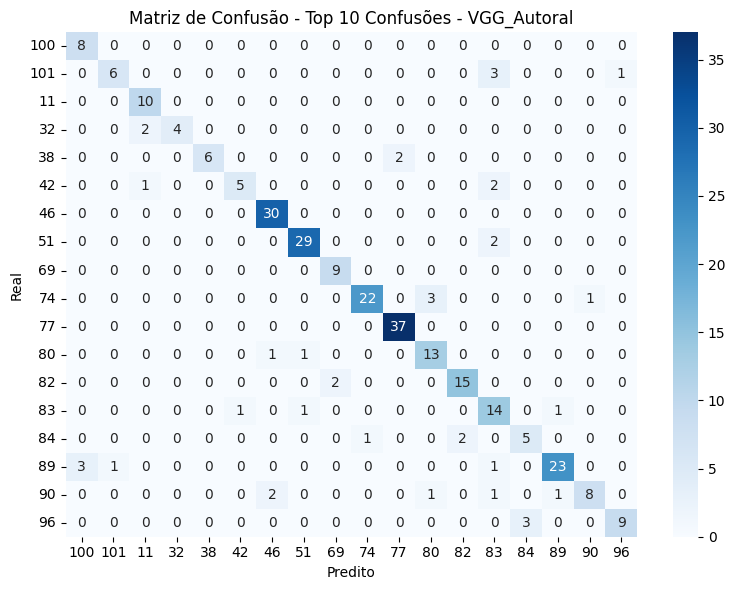

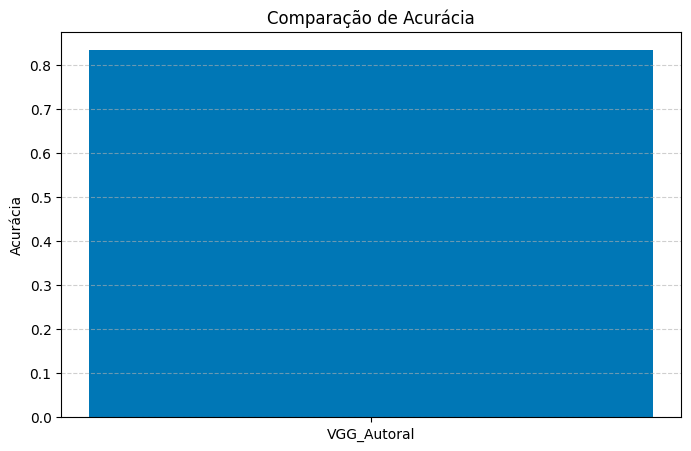


===== Treinando e avaliando dataset: Tiny-ImageNet =====

=== Iniciando treinamento ===

===== Dataset: Tiny-ImageNet =====

Treinando VGG_Autoral no dataset Tiny-ImageNet
Epoch [1/200] | Train Loss: 5.9454, Train Acc: 0.0064 | Val Loss: 5.2456, Val Acc: 0.0085
Epoch [2/200] | Train Loss: 5.1977, Train Acc: 0.0108 | Val Loss: 5.1189, Val Acc: 0.0144
Epoch [3/200] | Train Loss: 5.1005, Train Acc: 0.0170 | Val Loss: 5.0321, Val Acc: 0.0209
Epoch [4/200] | Train Loss: 5.0158, Train Acc: 0.0219 | Val Loss: 4.9097, Val Acc: 0.0330
Epoch [5/200] | Train Loss: 4.9123, Train Acc: 0.0309 | Val Loss: 4.7823, Val Acc: 0.0436
Epoch [6/200] | Train Loss: 4.7704, Train Acc: 0.0453 | Val Loss: 4.6187, Val Acc: 0.0649
Epoch [7/200] | Train Loss: 4.6048, Train Acc: 0.0595 | Val Loss: 4.4385, Val Acc: 0.0770
Epoch [8/200] | Train Loss: 4.4549, Train Acc: 0.0760 | Val Loss: 4.2890, Val Acc: 0.0949
Epoch [9/200] | Train Loss: 4.3202, Train Acc: 0.0941 | Val Loss: 4.1423, Val Acc: 0.1213
Epoch [10/200] | 

AttributeError: 'Subset' object has no attribute 'classes'

In [11]:
@staticmethod
def build_vgg_pretrained(variant, weights, num_classes):
    model = variant(weights=None) 
    
    model.classifier[6] = nn.Linear(4096, num_classes) 
    
    initialize_weights(model) 
    
    return model

if __name__ == "__main__":
    import torch
    from torchvision import models
    import matplotlib.pyplot as plt
    import gc

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Usando dispositivo: {device}")

    train_loaders, val_loaders, test_loaders = load_datasets()
    resultados_totais = {}

    def plot_metric_comparison(resultados, metric_name):
        nomes = list(resultados.keys())
        valores = [resultados[m][metric_name] for m in nomes]
        plt.figure(figsize=(8, 5))
        plt.bar(nomes, valores, color=['#0077b6', '#00b4d8', '#90e0ef'])
        plt.title(f"Comparação de {metric_name}")
        plt.ylabel(metric_name)
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.show()

    for dataset_name in train_loaders.keys():
        print(f"\n===== Treinando e avaliando dataset: {dataset_name} =====")
        train_loader = train_loaders[dataset_name]
        val_loader = val_loaders[dataset_name]
        test_loader = test_loaders[dataset_name]

        dataset_ref = train_loader.dataset
        
        if hasattr(dataset_ref, "dataset"):
            dataset_ref = dataset_ref.dataset
        num_classes = len(dataset_ref.classes)

        modelos = {
            "VGG11": build_vgg_pretrained(models.vgg11, models.VGG11_Weights.IMAGENET1K_V1, num_classes),
            "VGG13": build_vgg_pretrained(models.vgg13, models.VGG13_Weights.IMAGENET1K_V1, num_classes),
            "VGG16": build_vgg_pretrained(models.vgg16, models.VGG16_Weights.IMAGENET1K_V1, num_classes),
            "VGG19": build_vgg_pretrained(models.vgg19, models.VGG19_Weights.IMAGENET1K_V1, num_classes),
            "VGG_Autoral": VGG_Autoral(num_classes=num_classes),
        }

        for model in modelos.values():
            model.to(device)
            
        print("\n=== Iniciando treinamento ===")
        resultados_treino, modelos_treinados = run_experimento(
            modelos=modelos,
            train_loaders={dataset_name: train_loader},
            val_loaders={dataset_name: val_loader},
            device=device,
            epochs=200,
            patience=10
        )


        for model_name in modelos.keys():
            print(f"\n--- Avaliando modelo: {model_name} ---")
            
            model_treinado = modelos_treinados[(dataset_name, model_name)]
            
            metricas = Metrics.evaluate_model(model_treinado, test_loader, device=device)
            complexidade = Metrics.get_model_complexity(model_treinado)
            desempenho = Metrics.benchmark_model(model_treinado, device=device)

            resultados_totais[(dataset_name, model_name)] = {
                "Teste": metricas,
                "Treino": resultados_treino.get((dataset_name, model_name), {}),
                "Complexidade": complexidade,
                "Desempenho": desempenho
            }

            print("\nMétricas de teste:")
            for k, v in metricas.items():
                if isinstance(v, float):
                    print(f"{k}: {v:.4f}")
                else:
                    print(f"{k}: {v}")

            print("\nMétricas de treino:")
            for k, v in resultados_treino.get((dataset_name, model_name), {}).items():
                if isinstance(v, float):
                    print(f"{k}: {v:.4f}")
                else:
                    print(f"{k}: {v}")

            plot_top_confusion(
                metricas['Matriz_Confusão'],
                class_names=train_loaders[dataset_name].dataset.classes,
                top_k=10,  
                model_name=model_name
            )

        resultados_acuracia = {name: resultados_totais[(dataset_name, name)]["Teste"] for name in modelos.keys()}
        plot_metric_comparison(resultados_acuracia, "Acurácia")





In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)


True
NVIDIA GeForce RTX 5070 Ti
12.8


In [1]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()
